# Генерация фамилий по национальностям с помощью рекурретной сети на основе ячеек GRU

В данной работе будет создана модель, генерирующая фамилию человека в зависимости от выбранной национальности.

Для выполнения данной работы загрузим список фамилий в привязке к национальности с одного из веб-порталов с помощью парсинга.

Модель будет построена с помощью PyTorch и дополнительного фреймворка для обучения PyTorch Lighting.

Также выполним подбор гиперпараметров модели с помощью фреймворка Optuna.

In [1]:
#!pip install beautifulsoup4 pytorch-lightning optuna

In [2]:
from argparse import Namespace

import pandas as pd
import numpy as np
import random

from bs4 import BeautifulSoup

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import requests
import re
from time import sleep
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython import display
import optuna
from optuna.integration import PyTorchLightningPruningCallback

SEED = 2021

In [4]:
def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [5]:
set_seed(seed=SEED)

## 1. Cбор данных для модели

Спарсим фамилии к привязке к национальности с сайта https://imena-znachenie.ru и сохраним датафрейм в файл.

In [6]:
# Аргументы для генерации датафрейма
dataframe_args = Namespace(
    # Путь к файлу с фамилиями для сохранения исходного датафрейма
    raw_dataset_csv=f"surnames.csv",
    # Размер части для обучения
    train_proportion=0.7,
    # Размер части для валидации
    val_proportion=0.15,
    # Размер части для теста
    test_proportion=0.15,
    # Путь к файлу с фамилиями с данными разбиения на обучение, валидацию и тест
    output_munged_csv=f"surnames_with_splits.csv",
    seed=2021
)

In [7]:
def get_national_surnames():
    """ Создание списка фамилий по национальностям
    с сайта https://imena-znachenie.ru

    Результат
    ---------
    surnames : pandas dataframe
      Датафрейм с фамилиями по национальностям.
      Содержит колонки surname и nationality
    """

    data = []

    for index in tqdm(range(1, 429)):

        url = f"https://imena-znachenie.ru/familii/?PAGEN_1={index}"
        response = requests.get(url)
        soup = BeautifulSoup(response.text)
        for name_object in soup.find_all("p", attrs="news-item"):
            name = name_object.findChild("a").text.lower().strip()
            nationality = name_object.findChild("img", title=re.compile(r"фамилии")).get("title").strip().lower()
            nationality = nationality.split(" ")[0]
            data.append([name, nationality])
        sleep(1)

    surnames = pd.DataFrame(data, columns=["surname", "nationality"])
    surnames.drop_duplicates("surname", inplace=True)

    return surnames

In [8]:
# Запуск парсинга и получение базового датафрейма с фамилиями
df_surnames = get_national_surnames()

# Сохраняем базовый датафрейм в файл
df_surnames.to_csv(dataframe_args.raw_dataset_csv, index=False)

In [9]:
df_surnames = pd.read_csv(dataframe_args.raw_dataset_csv)
df_surnames[:10]

,surname,nationality
0,аарон,еврейские
1,ааронов,еврейские
2,ааронова,еврейские
3,абагян,армянские
4,абаджян,армянские
5,абае,еврейские
6,абаев,еврейские
7,абаева,еврейские
8,абазян,армянские
9,абаимов,русские


### 1.2 Предобработка данных

Проверим статистику фамилий по национальностям

In [10]:
df_surnames.groupby("nationality").count()

,surname
nationality,
английские,210
армянские,871
еврейские,11709
литовские,1
немецкие,25
осетинские,1081
русские,26673
японские,201


Удалим литовские и немецкие фамилии, так как их очень мало

In [11]:
df_surnames = df_surnames[~df_surnames.nationality.isin(["немецкие", "литовские"])].copy()
df_surnames.index = np.arange(len(df_surnames))
df_surnames.groupby("nationality").count()

,surname
nationality,
английские,210
армянские,871
еврейские,11709
осетинские,1081
русские,26673
японские,201


Разделим датасет на обучающую, валидационную и тестовую выборки с помощью стратифицированной выборки функции train_test_split из библиотеки sklearn

In [12]:
X_train, X_test = train_test_split(df_surnames, test_size=dataframe_args.test_proportion,
                                   stratify=df_surnames.nationality, random_state=dataframe_args.seed)
X_train, X_val = train_test_split(X_train, test_size=dataframe_args.val_proportion,
                                   stratify=X_train.nationality, random_state=dataframe_args.seed)

Статистика распределения фамилий по национальности для обучающей выборки

In [13]:
X_train.groupby("nationality").count()

,surname
nationality,
английские,151
армянские,629
еврейские,8460
осетинские,781
русские,19271
японские,146


Статистика распределения фамилий по национальности для валидационной выборки

In [14]:
X_val.groupby("nationality").count()

,surname
nationality,
английские,27
армянские,111
еврейские,1493
осетинские,138
русские,3401
японские,25


Статистика распределения фамилий по национальности для тестовой выборки

In [15]:
X_test.groupby("nationality").count()

,surname
nationality,
английские,32
армянские,131
еврейские,1756
осетинские,162
русские,4001
японские,30


Дополним исходный датасет столбцом с именем split, где будет находится тип разделения для каждого значения и сохраним данные в файл

In [16]:
df_surnames["split"] = None
split_index = np.where(df_surnames.columns == "split")[0][0]

In [17]:
df_surnames.iloc[X_test.index, split_index] = "test"
df_surnames.iloc[X_val.index, split_index] = "val"
df_surnames.iloc[X_train.index, split_index] = "train"

assert all(~df_surnames.split.isna()) == True

In [18]:
df_surnames.to_csv(dataframe_args.output_munged_csv, index=False)

## 2. Подготовка данных для работы модели

### 2.1 Вспомогательный класс Vocabulary

Базовый класс, который отвечает за кодирование слов и символов. Содержит базу (словарь) соответствия слов числовым индексам. Позволяет добавить новые слова и символы в базу.

In [19]:
class Vocabulary:
    """ Класс для кодирования слов и символов

    Параметры
    ---------
    token_to_idx : dict
      Словарь в формате {токен: индекс токена}
      По умолчанию None, будет создан чистый словарь.
    """
    def __init__(self, token_to_idx=None):

        if token_to_idx is None:
            token_to_idx = {}

        self.token_to_idx = token_to_idx
        self.idx_to_token = {i: k for k, i in token_to_idx.items()}

    def add_token(self, token):
        """ Добавление токена в словарь объекта

        Параметры
        ---------
        token : str
          Токен для добавления в словарь

        Результат 
        ---------
        index : int
          Индекс токена в словаре
        """
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def lookup_token(self, token):
        """ Поиск индекса для токена в словаре 

        Параметры
        ---------
        token : str
          Токен для поиска в словаре

        Результат
        ---------
        index : int
          Индекс токена в словаре
        """

        assert token in self.token_to_idx, f"Символ {token} отсутствует в словаре"
        return self.token_to_idx[token]

    def lookup_index(self, index):
        """ Поиск словая по индексу в словаре 

        Параметры
        ---------
        index : int
          Индекс для поиска в словаре

        Результат
        ---------
        token : str
          Токен для заданного индекса
        """
        assert index in self.idx_to_token, f"Индекс {index} отсутствует в словаре"
        return self.idx_to_token[index]

    def to_serializable(self):
        """ Формирование словаря с сериализованными параметрами объекта класса """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ Объект класса  Vocabulary из сериализованного словаря"""
        return cls(**contents)

    def __len__(self):
        return len(self.token_to_idx)

    def __str__(self):
        return f"<Vocabulary(len={len(self)})>"

### 2.2 Вспомогательный класс SequenceVocabulary

Данный класс наследуется от Vocabulary и предназначается для использования кодирования текстовых последовательностей. 
В частности класс при инициализации добавляет в базу метки для начала и окончания последовательности, метки для незнакомых слов и для маски.

In [20]:
class SequenceVocabulary(Vocabulary):
    """ Класс для кодирования текстовых последовательностей

    Параметры
    ---------
    token_to_idx : dict
      Словарь в формате {токен: индекс токена}
      По умолчанию None, будет создан чистый словарь.
    unk_token : str
      Токен для незнакомых слов. По умолчанию <UNK>
    mask_token : str
      Токен для маски. По умолчанию <MASK>
    begin_seq_token : str
      Токен для начала последовательности. По умолчанию <BEGIN>
    unk_token : str
      Токен для окончания последовательности. По умолчанию <END>    
    """
    def __init__(self, token_to_idx=None, unk_token="<UNK>", mask_token="<MASK>", 
                 begin_seq_token="<BEGIN>", end_seq_token="<END>"):
        
        super().__init__(token_to_idx=token_to_idx)

        self._unk_token = unk_token
        self._mask_token = mask_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.unk_index = self.add_token(unk_token)
        self.mask_index = self.add_token(mask_token)
        self.begin_seq_index = self.add_token(begin_seq_token)
        self.end_seq_index = self.add_token(end_seq_token)

    def lookup_token(self, token):
        """ Поиск словая по индексу в словаре.
        Если токен отсутствует в словаре, будет возвращен индекс для unk_token

        Параметры
        ---------
        index : int
          Индекс для поиска в словаре

        Результат
        ---------
        token : str
          Токен для заданного индекса
        """

        if token not in self.token_to_idx:
            return self.unk_index

        return self.token_to_idx[token]

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

### 2.3 Вспомогательный класс SurnameVectorizer

Класс отвечает за представление фамилий в вектора, которые могут использоваться для обучения модели.

Класс имеет метод vectorize, который возвращает вектор наблюдения (from_vector) и целевой вектор (to_vector). Вектор наблюдения - фамилия человека без последнего символа. А целевой вектор - фамилия человека без первого символа. С помощью данного смещения мы решаем задачу предсказания следующей буквы на каждом временном шаге модели.


Каждая буква фамилии переводится в числовой формат с помощью класса SequenceVocabulary. При этом в начало и в конец вектора фамилии вставляются коды начала и окончания последовательности соответственно. Символ начала последовательности нам потребуется в будущем для того, чтобы запустить случайную генерацию фамилии. А по символу окончания последовательности мы даем модели понять, когда заканчивается слово. И в будущем мы можем останавливать цикл генерации фамилии, если модель отдаст символ окончания последовательности во время генерации.

Так же метод vectorize принимает в виде параметра размер длины вектора результирующего вектора. Фамилии могут иметь разную длину. Чтобы упаковать все фамилии в один тензор необходимо, чтобы каждый вектор для обучения был одинаковой длины. Поэтому можно найти в датасете размер самой длинной фамилии и создавать векторы для всег фамилий по его длине. Для реализаации этой идеи в случае более короткой фамилии требуется заполнение вектора символом маскирования.

Предположим, что у нас самая длинная фамилия имеет длину 14. Так как к фамилии добавляются символы начала и длины последовательности, то длина вектора увеличивается до 16. Предположим, что необходимо сделать вектор для фамилии из 5 букв. 

**Тогда исходный вектор фамилии будет выглядеть следующим образом:**

BEGIN_SEQ + 5 символов фамилии + END_SEQ  

**Из данного вектора формируем вектор наблюдения следующим образом:**

BEGIN_SEQ + 5 символов фамилии + 9 * MASK  

**А вектор цели следующим образом:**

5 символов фамилии + END_SEQ + 9 * MASK

Итоговые длины векторов получились размером 15, а не 16. Так как из каждого вектора убирается один символ.

In [21]:
class SurnameVectorizer:
    """ Векторизатор для приведения в соответствие и использования 
    словарей фамилий и национальностей

    Параметры
    ---------
    char_vocab : SequenceVocabulary
      Словарь для символов фамилий
    nationality_vocab : SequenceVocabulary
      Словарь для национальностей
    """

    def __init__(self, char_vocab, nationality_vocab):

        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname, vector_length=-1):
        """ Векторизация фамилии в вектор наблюдения и цели

        Выходными данными являются векторизованная фамилия, разделенная на два вектора:
        surname[:-1] и surname[1:]
        На каждом временном шаге первый вектор - это наблюдение, а второй вектор - цель.

        Параметры
        ---------
        surname : str
          Фамилия
        vector_length : int
          Длина выходных векторов. По умолчанию -1, длина будет формироваться
          динамически в зависимости от длины фамилии. В параметр необходимо передавать
          реальную длину фамилии без учета дополнительных символов. Итоговый размер
          вектора будет на 2 больше, так как будут добавлены символы начала и окончания
          последовательности.

        Результат
        ---------
        from_vector, to_vector : np.array, np.array
          Вектор наблюдения и вектор цели
        """

        indices = [self.char_vocab.begin_seq_index]
        indices.extend([self.char_vocab.lookup_token(char) for char in surname])
        indices.append(self.char_vocab.end_seq_index)

        if vector_length == -1:
            vector_length = len(indices) - 1
        else: 
            vector_length += 2

        from_vector = np.zeros(vector_length, dtype=np.int64)
        from_indices = indices[:-1]
        from_vector[:len(from_indices)] = from_indices
        from_vector[len(from_indices):] = self.char_vocab.mask_index

        to_vector = np.zeros(vector_length, dtype=np.int64)
        to_indices = indices[1:]
        to_vector[:len(to_indices)] = to_indices
        to_vector[len(to_indices):] = self.char_vocab.mask_index

        return from_vector, to_vector

    @classmethod
    def from_dataframe(cls, surnames_df):
        """ Создание векторизатора на основе датафрейма surnames
        Датафрейм должен содержать столбцы surname и nationality

        Параметры
        ---------
        surnames_df : pandas dataframe
          Датафрейм с фамилиями и национальностями
        """

        char_vocab = SequenceVocabulary()
        nationality_vocab = Vocabulary()

        for _, row in surnames_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)

        return cls(char_vocab=char_vocab, nationality_vocab=nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """ Создание объекта класса с помощью сериализованных данных
        """
        char_vocab = SequenceVocabulary.from_serializable(contents['char_vocab'])
        nat_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])

        return cls(char_vocab=char_vocab, nationality_vocab=nat_vocab)

    def to_serializable(self):
        """ Получение сериализованных параметров объекта класса """
        return {'char_vocab': self.char_vocab.to_serializable(), 
                'nationality_vocab': self.nationality_vocab.to_serializable()}

### 2.4 Вспомогательный класс SurnameDataset

In [22]:
class SurnameDataset(Dataset):
    """ Генерация данных для обучения модели

    Датасет находит максимальную длину фамилии в общих данных
    и использует ее для генерации данных для модели.

    Класс имеет метод set_split, который переключает на лету датасет для
    генерации данных в зависимости от типа разделения данных. Для этого
    датафрейм с фамилиями должен сожержать столбец split, в котором 
    находится метка к какому типу разделения принадлежит фамилия.
    Может принимать значение train, val или test.

    Параметры
    ---------
    surname_df : pd.DataFrame
      Датафрейм с фамилиями. 
      Должен содержать колонки surname, nationality и split.
    vectorizer : SurnameVectorizer
      Объект класса векторизатора фамилий
    """

    def __init__(self, surname_df, vectorizer):

        assert set(surname_df.columns.values) == set(["surname", "nationality", "split"])
        assert set(surname_df.split.values) == set(["train", "val", "test"])

        super().__init__()

        self._surname_df = surname_df
        self._vectorizer = vectorizer
        self._max_seq_length = max(map(len, self._surname_df.surname.values))

        self._train_dataset = self._surname_df[self._surname_df.split == 'train'].copy()
        self._train_size = len(self._train_dataset)
        self._val_dataset = self._surname_df[self._surname_df.split == 'val'].copy()
        self._val_size = len(self._val_dataset)
        self._test_dataset = self._surname_df[self._surname_df.split == 'test'].copy()
        self._test_size = len(self._test_dataset)

        self._lookup_dict = {
            "train": (self._train_dataset, self._train_size),
            "val": (self._val_dataset, self._val_size),
            "test": (self._test_dataset, self._test_size),
        }

        self.set_split(mode="train")

    def set_split(self, mode="train"):
        """ Изменение датасета выдачи данных в зависимости от типа разделения
        
        Параметры
        ---------
        mode : str
          Режим. Может принимать значение train, val или test
        """
        mode = str(mode).lower().strip()
        assert mode in ("train", "val", "test")

        self._target_df, self._target_size = self._lookup_dict[mode]

    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_df):
        """ Создание объекта класса на основе датафрейма surnames

        Параметры
        ---------
        surname_df : pandas dataframe
          Датафрейм с фамилиями и национальностями. Должен содержать
          колонки surname и nationality
        """
        return cls(surname_df, SurnameVectorizer.from_dataframe(surname_df))

    def get_vectorizer(self):
        """ Вернуть векторизатор """
        return self._vectorizer

    def __len__(self):
        return self._target_size

    def __getitem__(self, idx):
        """ Возвращает элемент датасета по индексу
        На выдачу влияет режим, выбранный методом set_split.

        Результат в виде словаря с ледующем формате:
        {
            "x_data": вектор наблюдения,
            "target": вектор цели,
            "class_index": номер национальности,
        }
        """

        row = self._target_df.iloc[idx]
        from_vector, to_vector = self._vectorizer.vectorize(surname=row.surname, 
                                                            vector_length=self._max_seq_length)
        
        nationality_index = self._vectorizer.nationality_vocab.lookup_token(row.nationality)
        
        result = {
            "x_data": from_vector,
            "target": to_vector,
            "class_index": nationality_index,
        }
        
        return result

### 2.5 Вспомогательный класс SurnameDatamodule

Данный класс необходим для обучения модели с помощью PyToch Lighting.
Внутри себя использует SurnameDataset и класс DataLoader из PyTorch для генерации батчей.

In [23]:
class SurnameDatamodule(LightningDataModule):
    """ Модуль с датасетом SurnameDataset для использования
    PyTorch Lighting

    Формат всех словарей загрузчиков:
        {
            'batch_size': INT,
            'shuffle': BOOL,
            'num_workers': INT,
            'pin_memory': BOOL,
            'drop_last': BOOL,
        }
    Использутся параметры DataLoader из Pytorch.

    Параметры
    ---------
    surname_df : pd.DataFrame
      Датафрейм с фамилиями. 
      Должен содержать колонки surname, nationality и split.
    train_loader_params : dict
      Словарь параметров для загрузчика обучающего датасета.
      По умолчанию None, будут заданы стандартные параметры.
    val_loader_params : dict
      Словарь параметров для загрузчика валидационного датасета.
      По умолчанию None, будут заданы стандартные параметры.
    test_loader_params : dict
      Словарь параметров для загрузчика тестового датасета.
      По умолчанию None, будут заданы стандартные параметры.
    """

    def __init__(self, surname_df, train_loader_params=None, 
                 val_loader_params=None, test_loader_params=None):
        
        super().__init__()
        
        assert set(surname_df.columns.values) == set(["surname", "nationality", "split"])
        assert set(surname_df.split.values) == set(["train", "val", "test"])

        self._surname_df = surname_df

        if not train_loader_params:
            train_loader_params = {
                    'batch_size': 128,
                    'shuffle': True,
                    'num_workers': 1,
                    'pin_memory': False,
                    'drop_last': True,
              }

        if not val_loader_params:
            val_loader_params = {
                    'batch_size': 128,
                    'shuffle': False,
                    'num_workers': 1,
                    'pin_memory': False,
                    'drop_last': False
              }

        if not test_loader_params:
            test_loader_params = {
                    'batch_size': 128,
                    'shuffle': False,
                    'num_workers': 1,
                    'pin_memory': False,
                    'drop_last': False
              }

        self._train_loader_params = train_loader_params
        self._val_loader_params = val_loader_params
        self._test_loader_params = test_loader_params

    def get_vectorizer(self, mode='train'):
        if mode == "train":
            return self.train_dataset.get_vectorizer()
        elif mode == "val":
            return self.val_dataset.get_vectorizer()
        elif mode == "test":
            return self.test_dataset.get_vectorizer()
        else:
            raise Exception("Недопустимый параметр mode")

    def setup(self, stage=None):
        """ Настройка датасетов для загрузчиков

        Для каждого загрузчика создается отдельная копия SurnameDataset.
        У объекта класса SurnameDataset есть метод set_split. Но если для
        всех загрузчиков сделать единый объект SurnameDataset и переключать тип
        выдачи на лету в методах train_dataloader и других, то объект класса LightningDataModule в этом случае работает
        неверно. На данный момент такое решение является выходом из этой ситуации.
        """

        self.train_dataset = SurnameDataset.load_dataset_and_make_vectorizer(surname_df=self._surname_df.copy())
        self.train_dataset.set_split("train")

        self.val_dataset = SurnameDataset.load_dataset_and_make_vectorizer(surname_df=self._surname_df.copy())
        self.val_dataset.set_split("val")
        
        self.test_dataset = SurnameDataset.load_dataset_and_make_vectorizer(surname_df=self._surname_df.copy())
        self.test_dataset.set_split("test")

    def train_dataloader(self):
        return DataLoader(self.train_dataset, **self._train_loader_params)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, **self._val_loader_params)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, **self._test_loader_params)

### 2.6 Класс генерирующей модели SurnameGenerationModel

Данный класс используется дл обучения генерирующей модели. Во время обучения модели класс будет выводить графики фунции потерь Cross Entropy и дополнительной метрику Accuracy в конце каждой эпохи.

Так же с помощью метода make_surnames можно запустить демонстрациюнную генерацию случайных фамилий для каждой национальности.

#### Принципы построения модели

**1. Использование эмбеддинга национальности в качестве начального скрытого вектора**

Данной техникой можно задать для каждой национальности постоянное смещение. Таким образом модель может отличать одну национальность от другой и использовать эти знания как при обучении, так и при генерации данных.

**2. К каждому временному шагу присоединияем полносвязанный слой**

Это необходимо для предсказания символа на каждом временном шаге. Размер выхода полносвязанной сети равен размеру словаря символов. А вход - размеру выходных скрытых векторов на каждом временном шаге.

**3. Не штрафуем модель в функции ошибок за предсказания в позициях символов маски**

Для этого используем параметр ignore_index в функции F.cross_entropy

In [24]:
class SurnameGenerationModel(LightningModule):
    """ Модель для генерации последовательности фамилий

    Параметры
    ---------
    char_embedding_size : int
      Размер вектора эмбеддингов для символов фамилий.
    char_vocab_size : int
      Размер словаря символов фамилий.
    padding_idx : int
      Номер индекса символа неизвестных значений из словаря символов фамилий.
    mask_index : int
      Номер индекса символа маски
    num_nationalities : int
      Количество национальностей
    rnn_hidden_size : int
      Размер выходного скрытого вектора на каждом шаге
    rnn_num_layers : int
      Количество слоев RNN. По умолчанию 1.
    dropout_p : float
      Вероятность дропаута для полносвязанного слоя. По умолчанию 0.5
    learning_rate : float
      Скорость обучения
    l2_regularization : float
      Размер L2-регуляризации
    adam_betas : (float, float)
      b1 и b2 для оптимизатора AdamW.
    plot_epoch_loss : bool
      Напечатать ли график потерь в конце эпохи обучения. По умолчанию True
    """

    def __init__(self, char_embedding_size, char_vocab_size, padding_idx, mask_index,
                 num_nationalities, rnn_hidden_size, rnn_num_layers=1, dropout_p=0.5,
                 learning_rate=0.01, l2_regularization=1e-3, 
                 adam_betas=(0.9, 0.999), plot_epoch_loss=True):
        
        
        super().__init__()
        
        self.char_emb = nn.Embedding(num_embeddings=char_vocab_size,
                                     embedding_dim=char_embedding_size,
                                     padding_idx=padding_idx)
        
        self.nation_emb = nn.Embedding(num_embeddings=num_nationalities,
                                            embedding_dim=rnn_hidden_size)
        
        self.rnn = nn.GRU(input_size=char_embedding_size,
                          hidden_size=rnn_hidden_size,
                          num_layers=rnn_num_layers,
                          batch_first=True)
        
        self.fc = nn.Linear(in_features=rnn_hidden_size, 
                            out_features=char_vocab_size)
        
        self.dropout_p = dropout_p

        self.learning_rate = learning_rate
        self.adam_betas = adam_betas
        self.l2_regularization = l2_regularization
        self.plot_epoch_loss = plot_epoch_loss
        self.mask_index = mask_index
        self.rnn_num_layers = rnn_num_layers

        # Словарь для хранения значения ошибок на стадии обучения и валидации
        # Для значений типа train добавляем значение np.nan, так как при первом запуске модель вначале осуществляет
        # шаг валидации без обучения и добавляет значения в списки типа val. Это будет считаться эпохой №0.
        self.train_history = {
            'train_loss': [np.nan],
            'train_acc': [np.nan],
            'val_loss': [],
            'val_acc': [],
            'test_loss': [],
            'test_acc': [],
        }
        self.plot_epoch_loss = plot_epoch_loss

        self.save_hyperparameters()

    def forward(self, x_in, nationality_index, apply_softmax=False):

        x_embedded = self.char_emb(x_in)
        nation_embedded = self.nation_emb(nationality_index).unsqueeze(0)
        if self.rnn_num_layers > 1:
            nation_embedded = torch.vstack([nation_embedded]*self.rnn_num_layers)
        y_out, _ = self.rnn(x_embedded, nation_embedded)
        batch_size, seq_size, feet_size = y_out.shape
        y_out = y_out.contiguous().view(batch_size*seq_size, feet_size)
        y_out = self.fc(F.dropout(y_out, self.dropout_p))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        new_feet_size = y_out.shape[-1]
        y_out = y_out.view(batch_size, seq_size, new_feet_size)

        return y_out

    @staticmethod
    def _normalize_sizes(y_pred, y_true):
        """ Нормализация размеров тензоров

        Параметры
        ---------
        y_pred : torch.Tensor
          Выходные данные модели. Если тензор трехмерный, то преобразуем его
          в матрицу
        y_true : torch.Tensor
          Целевые предсказания. Если это матрица, то преобразуем в вектор
        """

        if len(y_pred.size()) == 3:
            y_pred = y_pred.view(-1, y_pred.size(2))
        if len(y_true.size()) == 2:
            y_true = y_true.view(-1)

        return y_pred, y_true

    def _sequence_loss(self, y_pred, y_true, mask_index):
        """ CrossEntropy с учетом маски"""
        y_pred, y_true = self._normalize_sizes(y_pred, y_true)
        return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

    def _compute_accuracy(self, y_pred, y_true, mask_index):
        """Расчет accuracy"""
        y_pred, y_true = self._normalize_sizes(y_pred, y_true)

        _, y_pred_indices = y_pred.max(dim=1)
        
        correct_indices = torch.eq(y_pred_indices, y_true).float()
        valid_indices = torch.ne(y_true, mask_index).float()
        
        n_correct = (correct_indices * valid_indices).sum().item()
        n_valid = valid_indices.sum().item()

        return n_correct / n_valid * 100

    def _share_step(self, batch, batch_idx, mode='train'):
        """ Общий шаг для обучения, валидации и теста

        Параметры
        ---------
        batch : dict
          Батч-словарь в следующем формате:
          {
          'x_data': список векторов-наблюдений,
          'target': список векторов-целей,
          'class_index': код национальности,
          }
        batch_idx : int
          Номер батча
        mode : str
          Режим. Используется только для префикса названий ошибок в логе.
          По умолчанию train
        """

        y_pred = self(x_in=batch["x_data"], nationality_index=batch["class_index"], 
                      apply_softmax=False)
        
        loss = self._sequence_loss(y_pred=y_pred, y_true=batch["target"], 
                                   mask_index=self.mask_index)
        
        self.log(f'{mode}_loss', loss, prog_bar=True)

        accuracy = self._compute_accuracy(y_pred=y_pred, y_true=batch["target"], 
                                          mask_index=self.mask_index)
        self.log(f'{mode}_acc', accuracy, prog_bar=True)

        return {"loss": loss, 'accuracy': accuracy}

    def training_step(self, batch, batch_idx):
        """Шаг обучения"""
        return self._share_step(batch, batch_idx, mode='train')

    def training_epoch_end(self, outputs):
        """Действия после окончания каждой эпохи обучения

        Параметры
        ---------
        outputs : list
          Список словарей. Каждый словарь - результат функции self._share_step для определенного батча на шаге обучения
        """

        # Считаем средние ошибки loss и rmse_loss по эпохе
        avg_train_loss = torch.tensor([x['loss'] for x in outputs]).detach().mean()
        avg_train_acc = torch.tensor([x['accuracy'] for x in outputs]).detach().mean()

        # Добавляем средние ошибки в словарь статистики обучения, используется для построение графиков
        self.train_history['train_loss'].append(avg_train_loss.numpy().item())
        self.train_history['train_acc'].append(avg_train_acc.numpy().item())

        # Если включено отображение графика обучения в конце эпохи, то рисуем графики
        if self.plot_epoch_loss:
            self.plot_history_loss()

    def validation_step(self, batch, batch_idx):
        """ Шаг валидации """
        return self._share_step(batch, batch_idx, mode='val')

    def validation_epoch_end(self, outputs):
        """Действия после окончания каждой эпохи валидации

        Параметры
        ---------
        outputs : list
          Список словарей.
          Каждый словарь - результат функции self._share_step для определенного батча на шаге валидации
        """

        # Считаем средние ошибки loss и rmse_loss по эпохе
        avg_val_loss = torch.tensor([x['loss'] for x in outputs]).detach().mean()
        avg_val_acc = torch.tensor([x['accuracy'] for x in outputs]).detach().mean()
        # Логируем ошибку валидации
        self.log(f'val_loss', avg_val_loss, prog_bar=True)

        # Добавляем средние ошибки в словарь статистики обучения, используется для построение графиков
        self.train_history['val_loss'].append(avg_val_loss.numpy().item())
        self.train_history['val_acc'].append(avg_val_acc.numpy().item())

        # Если включено отображение графика обучения в конце эпохи, то рисуем графики
        if self.plot_epoch_loss:
            self.plot_history_loss()

    def test_step(self, batch, batch_idx):
        """ Шаг теста """
        return self._share_step(batch, batch_idx, mode='test')

    def configure_optimizers(self):
        """Конфигурация оптимизатора и планировщика скорости обучения"""
        optimizer = optim.AdamW(self.parameters(), betas=self.adam_betas, lr=self.learning_rate,
                                weight_decay=self.l2_regularization)
        sheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                                  T_0=20,
                                                                  eta_min=1e-4)

        return [optimizer], [sheduler]


    def plot_history_loss(self, clear_output=True):
        """ Функция построения графика обучения в конце эпохи
        """

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].plot(np.arange(0, len(self.train_history['train_loss'])),
                     self.train_history['train_loss'],
                     label="train_loss")
        axes[0].scatter(np.arange(0, len(self.train_history['train_loss'])),
                     self.train_history['train_loss'])
        axes[0].plot(np.arange(0, len(self.train_history['val_loss'])),
                     self.train_history['val_loss'],
                     label="val_loss")
        axes[0].scatter(np.arange(0, len(self.train_history['val_loss'])),
                     self.train_history['val_loss'])
        axes[0].legend(loc='best')
        axes[0].set_xlabel("epochs")
        axes[0].set_ylabel("loss")
        val_loss_epoch_min = np.argmin(self.train_history['val_loss'])
        val_loss_min = self.train_history['val_loss'][val_loss_epoch_min]
        val_loss_min = round(val_loss_min, 3) if not np.isnan(val_loss_min) else val_loss_min
        title_min_vals = f'\nValidation minimum {val_loss_min} on epoch {val_loss_epoch_min}'
        axes[0].set_title('MODEL LOSS: Cross-Entropy'+title_min_vals)
        axes[0].grid()

        axes[1].plot(np.arange(0, len(self.train_history['train_acc'])),
        self.train_history['train_acc'], label="train_acc")
        axes[1].scatter(np.arange(0, len(self.train_history['train_acc'])),
                        self.train_history['train_acc'])
        axes[1].plot(np.arange(0, len(self.train_history['val_acc'])),
                        self.train_history['val_acc'], label="val_acc")
        axes[1].scatter(np.arange(0, len(self.train_history['val_acc'])),
                        self.train_history['val_acc'])
        axes[1].legend(loc='best')
        axes[1].set_xlabel("epochs")
        axes[1].set_ylabel("accuracy")
        acc_loss_epoch_max = np.argmax(self.train_history['val_acc'])
        acc_loss_max = self.train_history['val_acc'][acc_loss_epoch_max]
        acc_loss_max = round(acc_loss_max, 3) if not np.isnan(acc_loss_max) else acc_loss_max
        title_min_vals = f'\nValidation maximum {acc_loss_max} on epoch {acc_loss_epoch_max}'
        axes[1].set_title('MONITORING LOSS: Accuracy'+title_min_vals)
        axes[1].grid()

        plt.show()
        if clear_output:
            display.clear_output(wait=True)

    def _sample_from_model(self, vectorizer, nationalities, sample_size=20, 
                      temperature=1.0):
        """Sample a sequence of indices from the model
        
        Параметры
        ---------
        vectorizer : SurnameVectorizer
            Векторизатор фамилий
        nationalities : list
          Список индексов фамилий для генерации сэмпла
        sample_size : int
          Размер сэмпла
        temperature : float
          Подчеркивает или сворачивает распределение
          При 0.0 < temperature < 1.0  максимумы заостряются
          При temperature > 1.0 делает распределение более равномерным.

        Результат
        ---------
        indices : torch.Tensor: 
          Матрица индексов символов размером (num_samples, sample_size)
        """

        num_samples = len(nationalities)
        begin_seq_index = [vectorizer.char_vocab.begin_seq_index 
                        for _ in range(num_samples)]
        begin_seq_index = torch.tensor(begin_seq_index, 
                                    dtype=torch.int64).unsqueeze(dim=1)
        indices = [begin_seq_index]
        nationality_indices = torch.tensor(nationalities, dtype=torch.int64).unsqueeze(dim=0)
        h_t = self.nation_emb(nationality_indices)
        if self.rnn_num_layers > 1:
            h_t = torch.vstack([h_t]*self.rnn_num_layers)
        for time_step in range(sample_size):
            x_t = indices[time_step]
            x_emb_t = self.char_emb(x_t)
            rnn_out_t, h_t = self.rnn(x_emb_t, h_t)
            prediction_vector = self.fc(rnn_out_t.squeeze(dim=1))
            probability_vector = F.softmax(prediction_vector / temperature, dim=1)
            indices.append(torch.multinomial(probability_vector, num_samples=1))
        indices = torch.stack(indices).squeeze().permute(1, 0)
        return indices

    @staticmethod
    def _decode_samples(sampled_indices, vectorizer):
        """Декодирование сгенерированных сэмлов модели в символьные значения

        Параметры
        ---------
        sampled_indices : torch.Tensor
          Индексы из метода _sample_from_model
        vectorizer : SurnameVectorizer
          Векторизатор фамилий
        
        Результат
        ---------
        decoded_surnames : list
          Список декодирвоанных фамилий
        """
        decoded_surnames = []
        vocab = vectorizer.char_vocab
        
        for sample_index in range(sampled_indices.shape[0]):
            surname = ""
            for time_step in range(sampled_indices.shape[1]):
                sample_item = sampled_indices[sample_index, time_step].item()
                if sample_item == vocab.begin_seq_index:
                    continue
                elif sample_item == vocab.end_seq_index:
                    break
                else:
                    surname += vocab.lookup_index(sample_item)
            decoded_surnames.append(surname)

        return decoded_surnames

    def make_surnames(self, vectorizer, sample_size=5, temperature=1.0):
        """ Запуск генерации случайных фамилий

        Параметры
        ---------
        vectorizer : SurnameVectorizer
            Векторизатор фамилий
        sample_size : int
          Размер сэмпла. По умолчанию 5.
        temperature : float
          Подчеркивает или сворачивает распределение
          При 0.0 < temperature < 1.0  максимумы заостряются
          При temperature > 1.0 делает распределение более равномерным.

        Результат
        ---------
        Печать сгенерированных данных на экране
        """
        
        for index in range(len(vectorizer.nationality_vocab)):
            nationality = vectorizer.nationality_vocab.lookup_index(index)
            print("{}: ".format(nationality.capitalize()))
            sampled_indices = self._sample_from_model(vectorizer=vectorizer,  
                                                nationalities=[index] * sample_size, 
                                                temperature=temperature)
            for sampled_surname in self._decode_samples(sampled_indices, vectorizer):
                print("-  " + sampled_surname)

## 3 Конфигурация и обучение модели

In [25]:
# Для параметров конфигурации требуется инициализация датасета
surname_datamodule = SurnameDatamodule(df_surnames)
surname_datamodule.setup()

In [26]:
train_config = {'seed': SEED,
          'get_optim_params': True,
          'model': {
              "char_embedding_size": 1024, 
              "char_vocab_size": len(surname_datamodule.get_vectorizer().char_vocab), 
              "padding_idx": surname_datamodule.get_vectorizer().char_vocab.mask_index,
              "num_nationalities": len(surname_datamodule.get_vectorizer().nationality_vocab), 
              "rnn_hidden_size": 1024, 
              "rnn_num_layers": 3,
              "mask_index": surname_datamodule.get_vectorizer().char_vocab.mask_index,
              "dropout_p": 0.5,
              "learning_rate": 0.001, 
              "l2_regularization": 0.01, 
              "adam_betas": (0.9, 0.999), 
              "plot_epoch_loss": True,
          },
          'dataloader': {
              'train_loader_params': {
                    'batch_size': 128,
                    'shuffle': True,
                    'num_workers': 1,
                    'pin_memory': False,
                    'drop_last': True,
              },
              'val_loader_params': {
                    'batch_size': 128,
                    'shuffle': False,
                    'num_workers': 1,
                    'pin_memory': False,
                    'drop_last': False
              },
              'test_loader_params': {
                    'batch_size': 128,
                    'shuffle': False,
                    'num_workers': 1,
                    'pin_memory': False,
                    'drop_last': False
              }
          },
         'trainer': {
              'max_epochs': 100,
              'gpus': 1 if torch.cuda.is_available() else 0,
              'progress_bar_refresh_rate': 10,
              'resume_from_checkpoint': None,
          },
}

Запускаем обучение модели

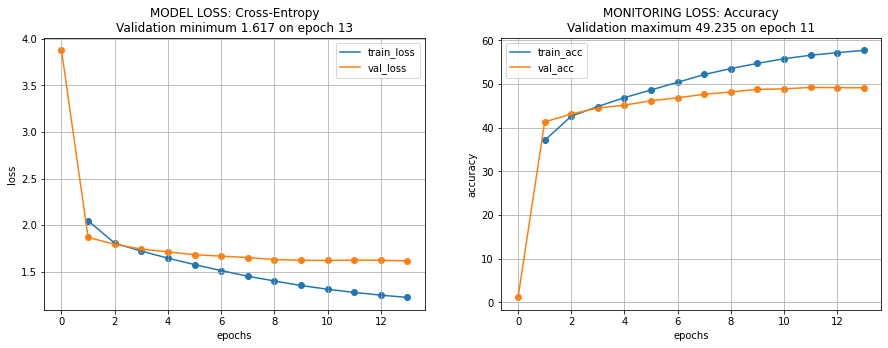

In [27]:
surname_datamodule = SurnameDatamodule(df_surnames, **train_config["dataloader"])
model = SurnameGenerationModel(**train_config["model"])

checkpoint = ModelCheckpoint(dirpath='checkpoint/', monitor='val_loss', mode='min')

callbacks = [
    EarlyStopping('val_loss', min_delta=0.01, patience=3, mode='min'), 
    checkpoint
]

trainer = pl.Trainer(callbacks=callbacks, **train_config['trainer'])

trainer.fit(model, surname_datamodule)

Загрузим лучшую модель из чекпоинта и проверим оценку на тестовой выборке

In [28]:
result = trainer.test(model, surname_datamodule, ckpt_path="best")

Restoring states from the checkpoint path at /content/checkpoint/epoch=12-step=2976-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/checkpoint/epoch=12-step=2976-v1.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 49.12651443481445, 'test_loss': 1.6049726009368896}
--------------------------------------------------------------------------------


Сгенерируем для каждой национальности по 5 фамилий

In [29]:
model.make_surnames(vectorizer=surname_datamodule.get_vectorizer(), sample_size=5, temperature=0.7)

Еврейские: 
-  бандуровский
-  смолиговская
-  минцкер
-  гельбербаум
-  пейсахов
Армянские: 
-  сагателян
-  варакян
-  парапетян
-  кирикоян
-  багумян
Русские: 
-  светланин
-  усков
-  катеринин
-  азарьев
-  курильчиков
Осетинские: 
-  хъамболтж
-  гжбжттотж
-  богъатж
-  арбиатж
-  тонжгатж
Японские: 
-  мотидзуки
-  окуяма
-  като
-  кавагути
-  нагаи
Английские: 
-  эпплтон
-  барперт
-  бард
-  берн
-  карпентер


Выведем примеры реальных фамилий для каждой национальности

In [30]:
for nationality in df_surnames.nationality.unique():
    print("{}: ".format(nationality.capitalize()))
    df = df_surnames[df_surnames.nationality == nationality]
    df.index = np.arange(len(df))
    indices = np.random.choice(df.index.values, size=5)
    sampled_surnames = df.iloc[indices, :]["surname"].values
    for sampled_surname in sampled_surnames:
                print("-  " + sampled_surname)

Еврейские: 
-  тулбович
-  ямбрус
-  натаров
-  бруксон
-  дворсон
Армянские: 
-  филикян
-  агаманян
-  есанян
-  торчанян
-  оганесян
Русские: 
-  рыжикова
-  недоспасова
-  фильчагина
-  тюменцева
-  печерина
Осетинские: 
-  атцетж
-  къелойтж
-  мичелтж
-  гасантж
-  долотж
Японские: 
-  ямамото
-  хасэгава
-  мацуи
-  кондо
-  тагути
Английские: 
-  фокс
-  вулф
-  парсонс
-  фрай
-  лав


Из результатов видно, что модель достаточно хорошо уловила особенности фамилий каждой национальности не смотря на большой дисбаланс классов.

**Как можно улучшить модель**
1. Использовать более современные архитектуры.
2. Улучшить качество датасета, убрать дисбаланс количества фамилий у каждой национальности путем добавления новых фамилий.